# Diabetic Retinopathy

## 1. Import Libraries

In [78]:
import numpy as np
import tensorflow as tf 
import os
from keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import seaborn as sns
from keras.applications.resnet50 import ResNet50


## 2. Image File Path Retrieval 

Get the images from each directory and construct full path using os like this:

"gaussian_filtered_images/images\Mild\0024cdab0c1e.png"

In [79]:
for dirname, _, filenames in os.walk('gaussian_filtered_images/images'):
    for filename in filenames:
        os.path.join(dirname, filename)

## 3. Learning Rate Schedule Function

This cell defines a function lr_rate that takes the current epoch and learning rate as input and adjusts the learning rate based on different conditions. It starts with a higher learning rate for the first five epochs, then decreases it for epochs 5 to 10, and gradually decreases it further afterward. The learning rate is a factor by which the weights of the network are updated during each iteration of the optimization algorithm.

In [80]:
# Function to calculate learning rate
def lr_rate(epoch, lr):
    if epoch < 5:
        lr = 0.0001
        return lr
    elif 5 <= epoch <= 10:
        lr = 0.00005
        return lr
    else:
        lr = lr * (epoch / (1 + epoch))
        return lr

## 4. Data Preprocessing and Augmentation Setup

This cell sets up an ImageDataGenerator for data augmentation and creates two data generators (train_data and valid_data) using the provided directory structure. It rescales the pixel values to be in the range [0, 1], applies zooming and shifting transformations, and splits the data into training and validation sets.

In [81]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = datagen.flow_from_directory('gaussian_filtered_images/images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('gaussian_filtered_images/images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


### Sample Images

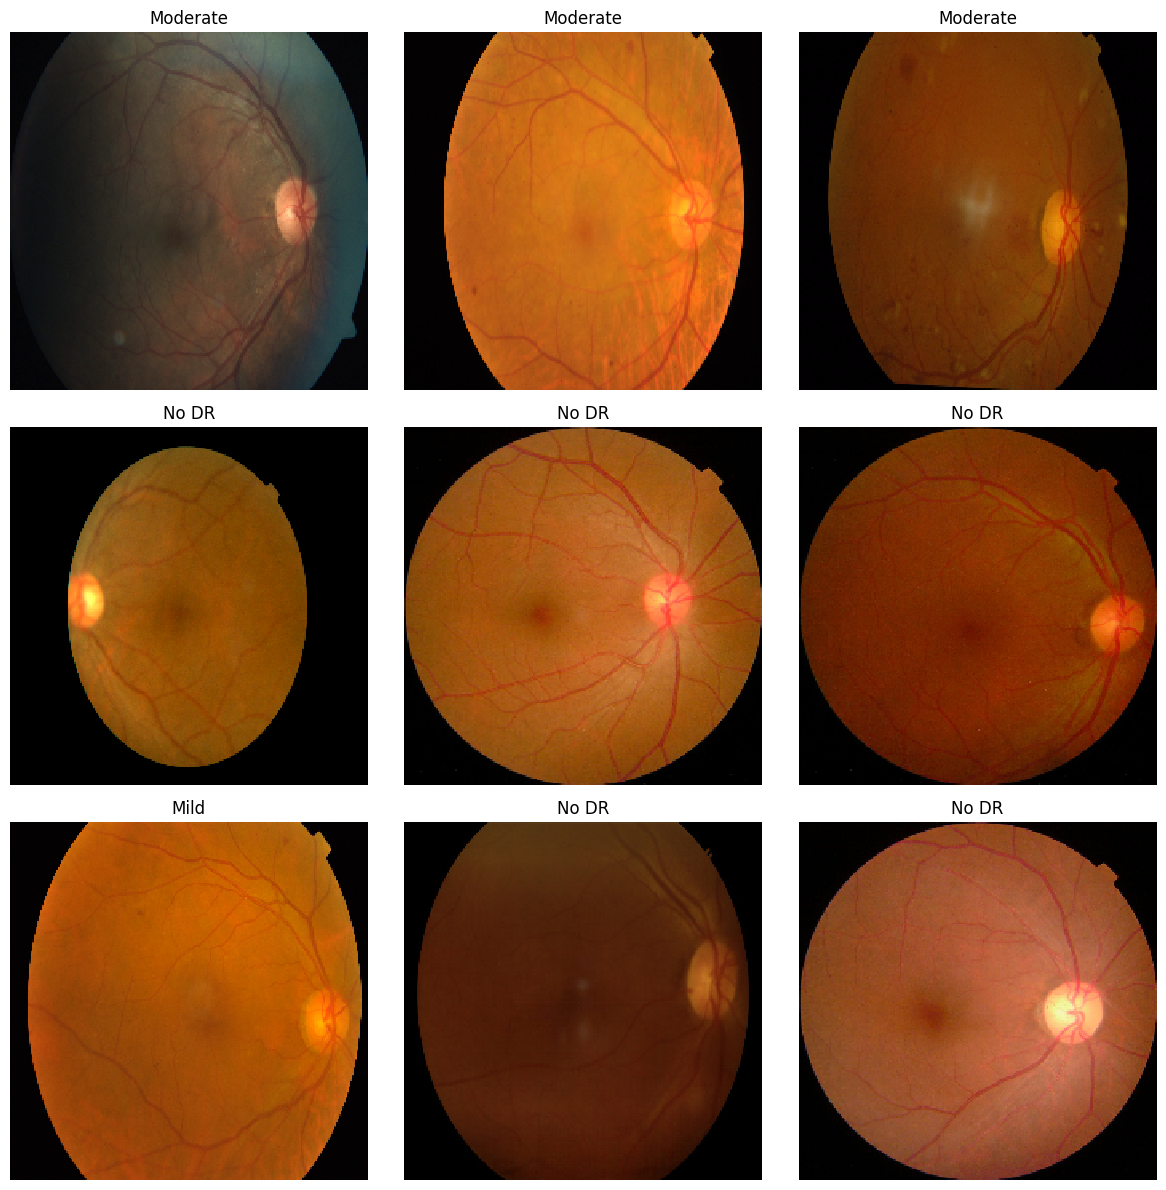

In [82]:
plt.figure(figsize=(12,12))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    for X_batch, Y_batch in train_data:
        image = X_batch[0]
        dic = {0:'Mild', 1:'Moderate', 2:'No DR', 3:'Proliferative DR', 4:'Severe'}
        plt.title(dic.get(np.argmax(Y_batch[0])))
        plt.axis('off')
        plt.imshow(np.squeeze(image), cmap='gray', interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## 5. Callback Setup for Early Stopping and Learning Rate Scheduling

lr_callback is a learning rate scheduler callback that adjusts the learning rate during training using the previously defined lr_rate function.

In [83]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_rate)

## 6. Model Definition and Compilation

### EfficientNet Model

This cell defines a convolutional neural network (CNN) model using the EfficientNetB0 architecture pre-trained on ImageNet. It adds global average pooling, dropout, batch normalization, and a dense output layer with softmax activation for multiclass classification. The model is compiled with Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric. Adam is an optimization algorithm used to update network weights iteratively during training

In [84]:
# Build and compile the model
ef_model = tf.keras.Sequential([
    efn.EfficientNetB0(
        input_shape=(224,224, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='softmax')
])

ef_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

### ResNet Model

In [85]:
# Build and compile the model
resnet_model = tf.keras.Sequential([
    ResNet50(
        input_shape=(224,224, 3),
        weights='imagenet',
        include_top=False
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='softmax')
])

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

## 7. Model Training

This cell trains the model using the fit_generator method. It specifies the training and validation data, along with the callback for adjusting the learning rate. The training runs for 15 epochs, and the training progress is stored in the history variable for later analysis.

In [86]:
# Train EfficentNet model
ef_history = ef_model.fit_generator(train_data,
                              validation_data=valid_data,
                              callbacks=lr_callback,
                              epochs=10,
                              verbose=1
                             )

# Train ResNet model
resnet_history = resnet_model.fit_generator(train_data,
                              validation_data=valid_data,
                              callbacks=lr_callback,
                              epochs=10,
                              verbose=1
                             )


C:\Users\AyhanÇavdar\AppData\Local\Temp\ipykernel_9756\294156140.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  ef_history = ef_model.fit_generator(train_data,


Epoch 1/2


 3/92 [..............................] - ETA: 5:03 - loss: 2.1828 - acc: 0.2396

KeyboardInterrupt: 

## 8. Define A Function For Plotting Training and Validation Curves

It takes the training and validation data, a title for the plot, and a subplot number as inputs. 

In [ ]:
# Plot training curves
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

This cell uses the display_training_curves function to plot two sets of curves: one for the loss (211 subplot) and another for accuracy (212 subplot). 

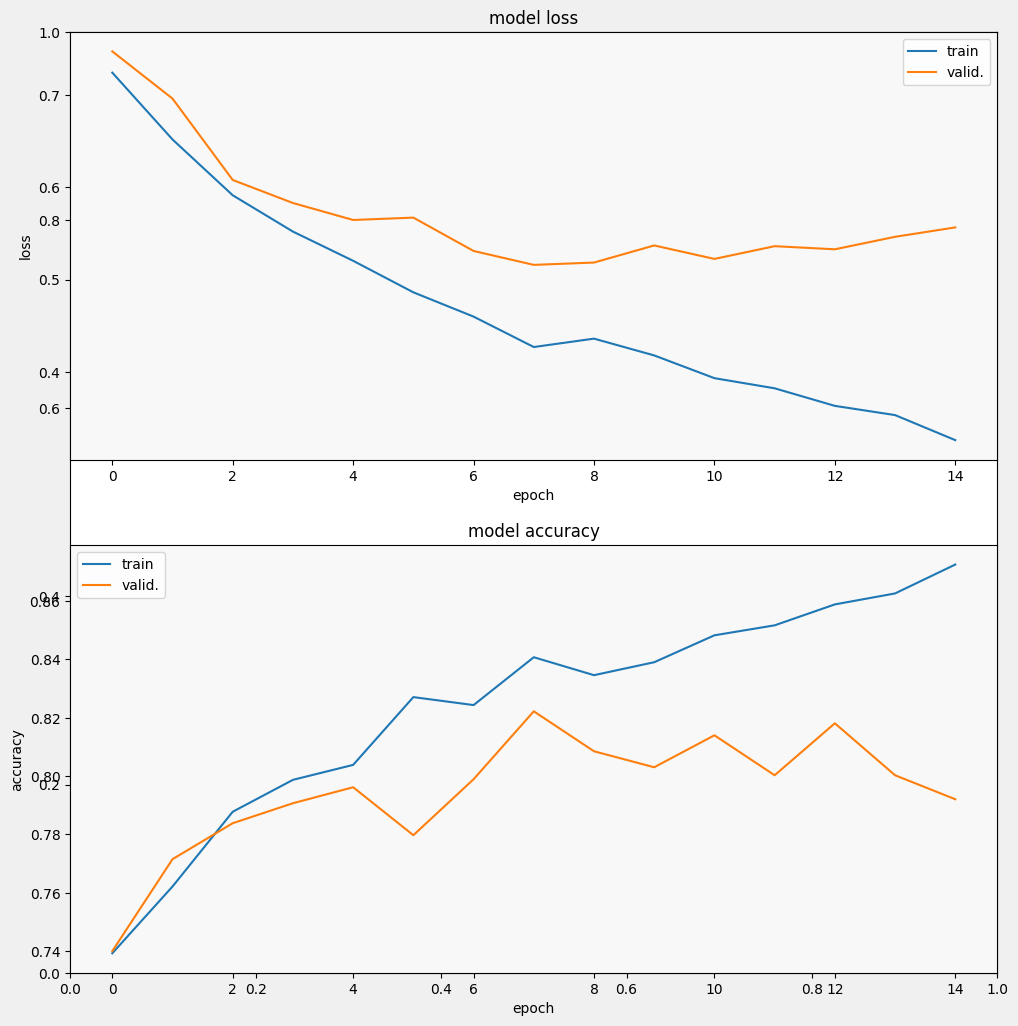

In [ ]:
display_training_curves(
    ef_history.history['loss'],
    ef_history.history['val_loss'],
    'loss (effnet)',
    211
)

display_training_curves(
    ef_history.history['acc'],
    ef_history.history['val_acc'],
    'accuracy (effnet)',
    212
)

In [ ]:
display_training_curves(
    resnet_history.history['loss'],
    resnet_history.history['val_loss'],
    'loss (resnet)',
    211
)

display_training_curves(
    resnet_history.history['acc'],
    resnet_history.history['val_acc'],
    'accuracy (resnet)',
    212
)

The model loss plot shows how well the model fits the data. A lower loss means a better fit. The model accuracy plot shows how well the model predicts the correct labels. A higher accuracy means a better prediction. From the plots, we can see that our model has a good performance on both training and validation data. The loss decreases and the accuracy increases over time for both data sets. This means that our model is learning from the data and generalizing well to new data.

## 9. Evaluation of The Model

F1 score is a metric that combines precision and recall. It's particularly useful for imbalanced datasets. AUC is a metric for evaluating the discriminatory power of a model across different classes. The F1 score is relatively low and suggests that the model's precision and recall are not well-balanced. The AUC score is slightly above 0.5, indicating some discriminatory power, but it's not highly reliable

In [ ]:
# Evaluate the EfficentNet model
y_actual = valid_data.labels
y_predicted_prob_ef = ef_model.predict(valid_data)
y_predicted_ef = np.argmax(y_predicted_prob_ef, axis=1)

# Calculate the F1 score and AUC for EfficientNet model
f1 = f1_score(y_actual, y_predicted_ef, average='macro')
auc = roc_auc_score(y_actual, y_predicted_prob_ef, average='macro', multi_class='ovo')

# Print the results
print('F1 score of EfficientNet:', f1)
print('AUC score of EfficientNet:', auc)

23/23 [==============================] - 16s 635ms/step
F1 score: 0.18684304681781053
AUC: 0.5085188874720071


In [ ]:
# Evaluate the ResNet model
y_predicted_prob_resnet = resnet_model.predict(valid_data)
y_predicted_resnet = np.argmax(y_predicted_prob_resnet, axis=1)

# Calculate the F1 score and AUC for ResNet model
f1 = f1_score(y_actual, y_predicted_resnet, average='macro')
auc = roc_auc_score(y_actual, y_predicted_prob_resnet, average='macro', multi_class='ovo')

# Print the results
print('F1 score of ResNet:', f1)
print('AUC score of ResNet:', auc)

## 10. Compute Confusion Matrix

- The model has a high recall for the No_DR class, which means that it correctly identified most of the images that do not have any DR.
- The model has a low precision for the Mild class, which means that it predicted many images as Mild when they actually belong to other classes.
- The model seems to have difficulty distinguishing between Mild and Moderate classes, as well as between Proliferate_DR and Severe classes. 

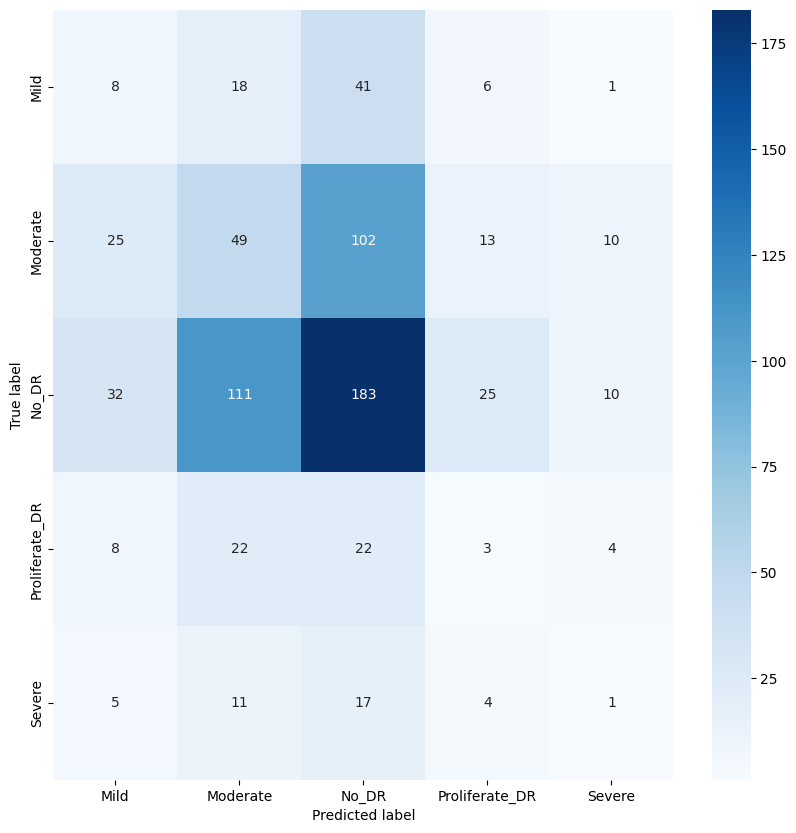

In [ ]:
# Compute the confusion matrix of EfficientNet model
cm = confusion_matrix(y_actual, y_predicted_ef)

# Define the class names
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Plot the confusion matrix with labels
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Compute the confusion matrix of ResNet model
cm = confusion_matrix(y_actual, y_predicted_resnet)

# Define the class names
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

# Plot the confusion matrix with labels
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()